# Advanced Lane Detection

## Steps

1. Camera Calibration
2. Perspective transformation
3. Thresholding using Color, Gradient, Magnitude and Direction
4. Locate Lane lines - Sliding window search
5. Lane polynomial fit
6. Use Lane detection or prediction

## Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

img_glob = 'camera_cal/cal*.jpg'

def calibrate_camera(img_glob):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(img_glob)

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img', img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    return objpoints, imgpoints
    
objpoints, imgpoints = calibrate_camera(img_glob)

## Undistort Images using calibrated points

In [2]:
def cal_undistort(img, objpoints, imgpoints):
   
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                        imgpoints, 
                                                        (img.shape[1], img.shape[0]), 
                                                        None, 
                                                        None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    
    return undist

## Undistort test image

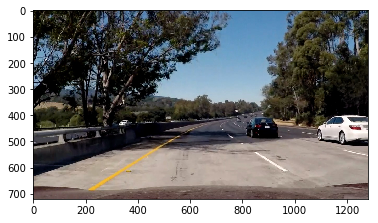

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

test_img = mpimg.imread('test_images/test5.jpg')
plt.imshow(test_img)

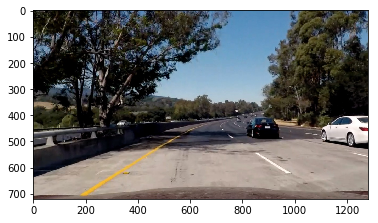

In [5]:
undist_test_img = cal_undistort(test_img, objpoints, imgpoints)
plt.imshow(undist_test_img)

## Perspective Transform

In [6]:
def get_perspective_transform(img):
    
    debug = False
    imshape = undist_test_img.shape
    thickness = 10

    left_bottom = (257, 685)
    right_bottom = (1050, 685)

    left_top =  (583, 460)
    right_top = (702, 460)
    
    if debug:
        cv2.line(img, left_bottom, left_top, [0,255,0], thickness)
        cv2.line(img, right_bottom, right_top, [0,255,0], thickness)
        cv2.line(img, left_top, right_top, [0,255,0], thickness)
        cv2.line(img, left_bottom, right_bottom, [0,255,0], thickness)

    src = np.float32((left_bottom, right_bottom, left_top, right_top))

    left_bottom = (300,  imshape[0])
    right_bottom = (imshape[1]-300, imshape[0])

    left_top =  (300, 0)
    right_top = (imshape[1]-300, 0)

    dst = np.float32((left_bottom, right_bottom, left_top, right_top))

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (imshape[1], imshape[0]), flags = cv2.INTER_LINEAR)
    un_warped = cv2.warpPerspective(warped, M_inv, (imshape[1], imshape[0]), flags = cv2.INTER_LINEAR)
    return warped, un_warped, M, M_inv

In [7]:
warped, un_warped, M, M_inv = get_perspective_transform(undist_test_img)

In [8]:
# Plot two images to compare
def plot_two_images(img1, img2, title1 = 'Original', title2 = 'Pipeline Result'):  
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=40)

    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

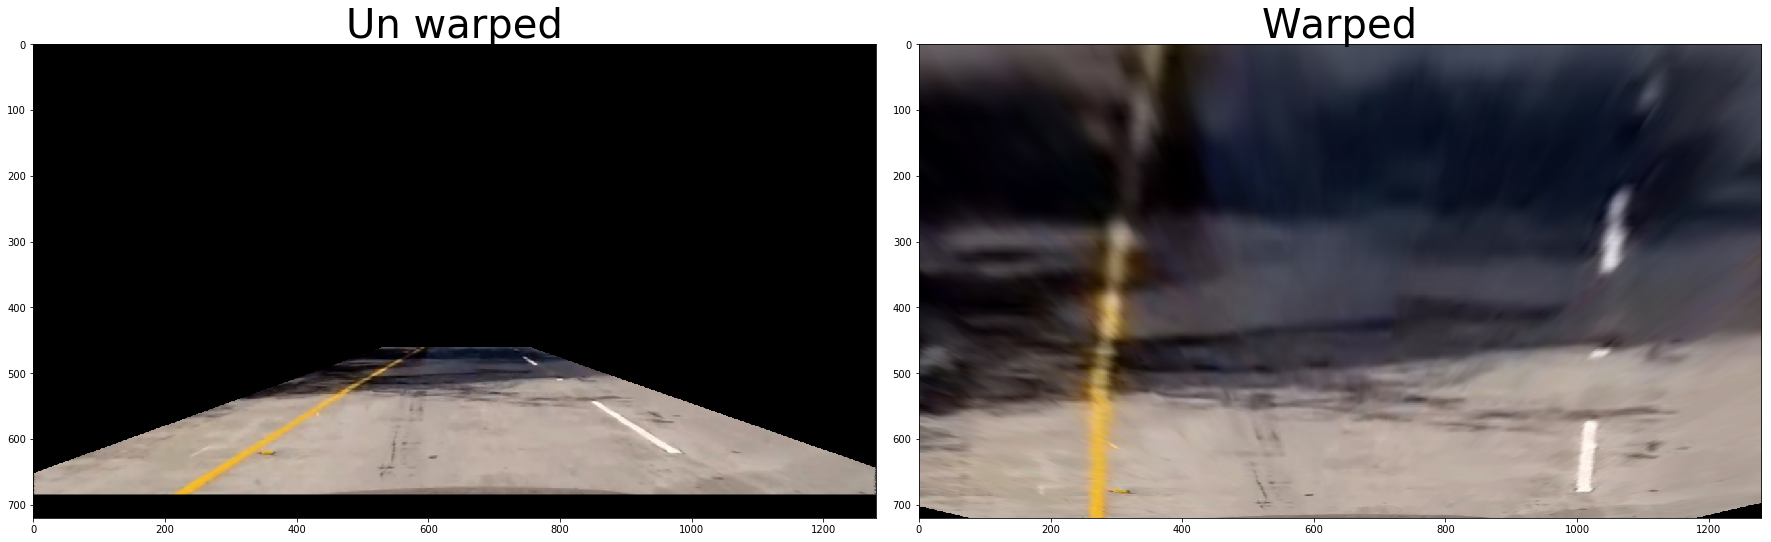

In [9]:
plot_two_images(un_warped, warped, title1 = 'Un warped', title2 = 'Warped')

## Color Thresholding Option # 1 - Using HLS color space

In [10]:
def color_threshold_pipeline1(img, s_thresh=(170, 255), sx_thresh=(20, 100), l_thresh = (40, 255)):
    
    img = np.copy(img)
    # Convert to HLS color space and separate the L and S channels
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel > sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel - S
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold color channel - S
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    # Stack each channel
    color_channels = 255 * np.dstack(( l_channel, sxbinary, s_binary)).astype('uint8')
    
    # Combined binary
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((l_binary == 1) & (s_binary == 1)) | (sxbinary == 1)] = 1

    return color_channels, combined_binary

In [15]:
color_channels, combined_binary = color_threshold_pipeline1(warped)

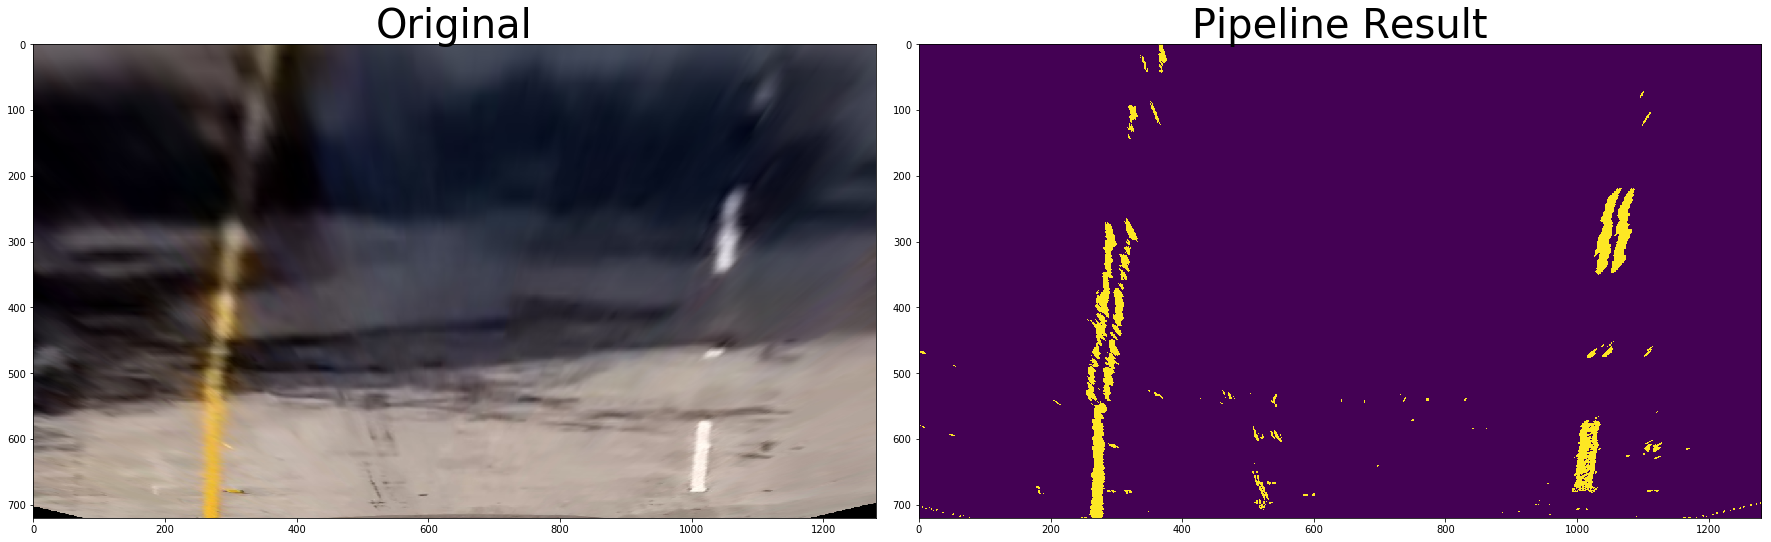

In [16]:
plot_two_images(warped, combined_binary)

## Color Thresholding Option # 2 - Using LAB color space

In [13]:
# Will be using L and B channels - ignoring A channel

def color_threshold_pipeline2(img, l_thresh=(220, 255), sx_thresh=(20, 100), b_thresh = (190, 255)):
    
    img = np.copy(img)
    # Convert to LAB color space and separate the L & B channels
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float)
    l_channel = lab[:,:,0]
    b_channel = lab[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel > sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel - L
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold color channel - B
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel > b_thresh[0]) & (b_channel <= b_thresh[1])] = 1

    # Stack each channel
    color_channels = 255 * np.dstack(( l_channel, sxbinary, b_binary)).astype('uint8')
    
    # Combined binary
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((l_binary == 1) & (b_binary == 1)) | (sxbinary == 1)] = 1

    return color_channels, combined_binary

### Seems both pipelines seem to provide decent results

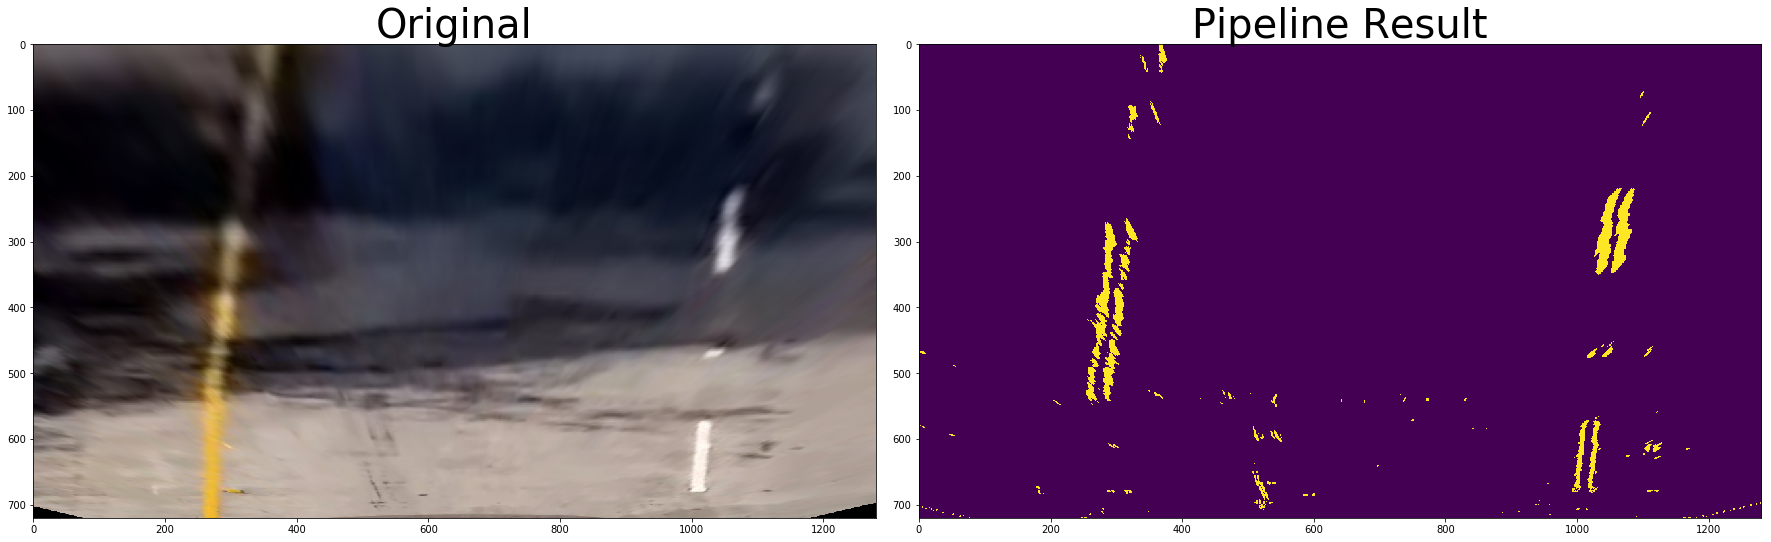

In [14]:
color_channels, combined_binary = color_threshold_pipeline2(warped)
plot_two_images(warped, combined_binary)

## Sliding Window - Polynomial fit - Histogram Approach

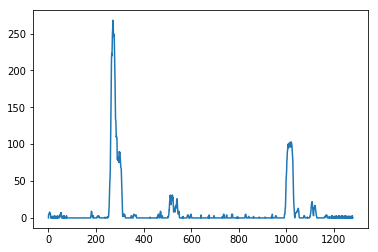

In [17]:
histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis = 0)
plt.plot(histogram)

In [18]:
def sliding_window_fit(combined_binary):
    
    out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(combined_binary.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = combined_binary.shape[0] - (window+1)*window_height
        win_y_high = combined_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_lane_inds, right_lane_inds, left_fit, right_fit

left_lane_inds, right_lane_inds, left_fit, right_fit = sliding_window_fit(combined_binary)

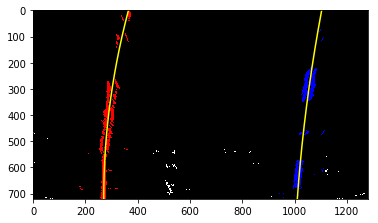

In [19]:
def plot_sliding_window_fit(img, left_lane_inds, right_lane_inds, left_fit, right_fit):
    
    out_img = np.dstack((img, img, img))*255
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

plot_sliding_window_fit(combined_binary, left_lane_inds, right_lane_inds, left_fit, right_fit)    

## Sliding Window Fit - Convolutions Approach

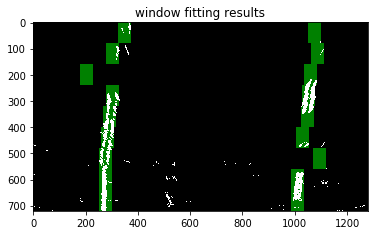

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def sliding_window_fit_convolutions(combined_binary):
    window_centroids = find_window_centroids(combined_binary, window_width, window_height, margin)
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(combined_binary)
        r_points = np.zeros_like(combined_binary)

        # Go through each level and draw the windows 
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,combined_binary,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,combined_binary,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.dstack((combined_binary, combined_binary, combined_binary))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((combined_binary,combined_binary,combined_binary)),np.uint8)

    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()
    
sliding_window_fit_convolutions(combined_binary)

## Sliding Window fit from previous window

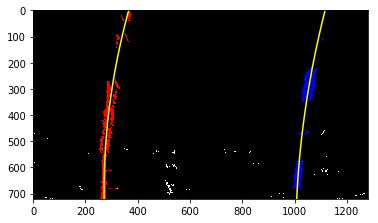

In [21]:
def sliding_window_fit_from_prev_frame(img, left_fit_prev, right_fit_prev):
    
    debug = False
    
    if (debug == True):
        print("sliding window fit using previous frame")
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
      
    margin = 50
    
    left_lane_inds = ((nonzerox >= (left_fit_prev[0] * (nonzeroy ** 2) 
                                   + left_fit_prev[1] * nonzeroy 
                                   + left_fit_prev[2] - margin)) & 
                    (nonzerox < (left_fit_prev[0] * (nonzeroy ** 2) 
                                 + left_fit_prev[1] * nonzeroy 
                                 + left_fit_prev[2] + margin)))
        
    right_lane_inds = ((nonzerox >= (right_fit_prev[0] * (nonzeroy ** 2) 
                                    + right_fit_prev[1] * nonzeroy 
                                    + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0] * nonzeroy ** 2 
                                    + right_fit_prev[1] * nonzeroy 
                                    + right_fit_prev[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if (len(leftx) != 0) and (len(rightx) != 0):
        left_fit_new = np.polyfit(lefty, leftx, 2)
        right_fit_new = np.polyfit(righty, rightx, 2)
    else:
        left_lane_inds, right_lane_inds, left_fit_new, right_fit_new = sliding_window_fit(combined_binary)

    return left_lane_inds, right_lane_inds, left_fit_new, right_fit_new

left_lane_inds, right_lane_inds, left_fit_new, right_fit_new = sliding_window_fit_from_prev_frame(combined_binary, 
                                                                   left_fit, 
                                                                   right_fit)

plot_sliding_window_fit(combined_binary, 
                        left_lane_inds, 
                        right_lane_inds, 
                        left_fit_new, 
                        right_fit_new)

## Determine Radius of Curvature

2200.73508757 1861.81434034
720.027376272 m 611.090216992 m


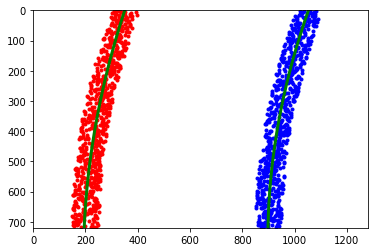

In [22]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

In [109]:
def radius_of_curvature(left_fit, right_fit, left_lane_inds, right_lane_inds, img):
    
    debug = False
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    nonzero = img.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    
    lefty = nonzeroy[left_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if (debug == True):
        print("left_fit = " + str(left_fit))
        print("right_fit = " + str(right_fit))
        plt.imshow(img)
        plt.show()
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
   
        
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    if (debug == True):
        print("left_curverad = " + str(left_curverad))
        print("right_curverad = " + str(right_curverad))
        
    return left_curverad, right_curverad

## Vehicle Distance from Lane Center

In [98]:
def calc_vehicle_distance_from_center(width, height, left_fit, right_fit):
    bottom_y = height - 1
    
    leftx = left_fit[0] * (bottom_y ** 2) + left_fit[1] * bottom_y + left_fit[2]
    rightx = right_fit[0] * (bottom_y ** 2) + right_fit[1] * bottom_y + right_fit[2]
    
    vehicle_offset = abs((width / 2) - (leftx + rightx) / 2)
    
    # conversion from pixels to meters
    vehicle_offset *= 3.7/700
    
    return vehicle_offset
    

## Line class

In [83]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # Recent Frame count processed
        self.frame_count = 0
        # Total Frame count processed
        self.total_frame_count = 0
    
    def add_fit(self, height, line_fit, line_ind, radius, distance):
        debug = False
        ploty = np.linspace(0, height-1, height)
        line_fitx = line_fit[0]*ploty**2 + line_fit[1]*ploty + line_fit[2]
        self.recent_xfitted = line_fitx
        self.current_fit.append(line_fit)
        self.radius_of_curvature = radius
        self.line_base_pos = distance
        self.total_frame_count += 1
        if (debug == True):
            print("self.total_frame_count  = " + str(self.total_frame_count))
        
        if self.total_frame_count > 5:
            self.detected = True
            last_5_fits = self.current_fit[-5:]
            self.best_fit = np.average(last_5_fits, axis = 0)
            self.bestx = self.best_fit[0]*ploty**2 + self.best_fit[1]*ploty + self.best_fit[2]
            self.diffs = abs(self.best_fit - line_fit)
            
            if (self.diffs[0] > 0.002 or self.diffs[1] > 1 or self.diffs[2] > 100):
                self.detected = False
        
        if (debug == True):
            print("DEBUG: self.best_fit = " + str(self.best_fit))
            print("DEBUG: self.detected = " + str(self.detected))
            print("DEBUG: self.diffs = " + str(self.diffs))

## Results

In [84]:
def lane_detect(undist_img, warped_img, left_fit, right_fit): 
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    
    # Y-coordinates along the image y-axis
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
    
    # Get left and right x-coordinates
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (combined_binary.shape[1], combined_binary.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    return result

## End to End Pipeline - Basic

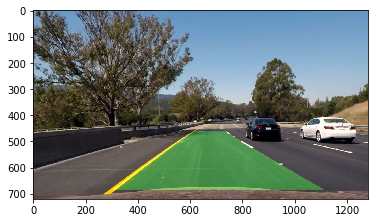

In [85]:
def process_image1(img):  
    undist_test_img = cal_undistort(img, objpoints, imgpoints)
    warped, un_warped, M, M_inv = get_perspective_transform(undist_test_img)
    color_channels, combined_binary = color_threshold_pipeline1(warped)
    left_lane_inds, right_lane_inds, left_fit, right_fit = sliding_window_fit(combined_binary) 
    result = lane_detect(undist_test_img, combined_binary, left_fit, right_fit)
    return result

test_img = mpimg.imread('test_images/test6.jpg')
result = process_image1(test_img)
plt.imshow(result)

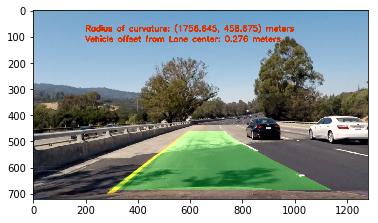

In [113]:
def process_image2(img): 
    debug = False
    undist_test_img = cal_undistort(img, objpoints, imgpoints)
    warped, un_warped, M, M_inv = get_perspective_transform(undist_test_img)
    color_channels, combined_binary = color_threshold_pipeline1(warped)
    
    if left_line.detected == True and right_line.detected == True:
        left_lane_inds, right_lane_inds, left_fit, right_fit = sliding_window_fit_from_prev_frame(combined_binary, 
                                                                                                  left_line.best_fit, 
                                                                                                  right_line.best_fit)
    else:
        left_lane_inds, right_lane_inds, left_fit, right_fit = sliding_window_fit(combined_binary)
    
    left_line.add_fit(combined_binary.shape[0], left_fit, left_lane_inds, radius=0, distance = 0)
    right_line.add_fit(combined_binary.shape[0], right_fit, right_lane_inds, radius=0, distance = 0)
                                                                                                          
    result = lane_detect(undist_test_img, combined_binary, left_fit, right_fit)
    if (debug == True):
        print("left_fit = " + str(left_fit))
        print("right_fit = " + str(right_fit))

    left_curve_radius, right_curve_radius = radius_of_curvature(left_fit, 
                                                                right_fit,
                                                                left_lane_inds,
                                                                right_lane_inds,    
                                                                combined_binary)
    vehicle_offset = calc_vehicle_distance_from_center(combined_binary.shape[1], combined_binary.shape[0], left_fit, right_fit)
    
    if debug == True:
        print("Left curve radius = " + str(left_curve_radius))
        print("Right curve radius = " + str(right_curve_radius))
        print("vehicle offset = " + str(vehicle_offset))

    curvature_string = 'Radius of curvature: ' + '(' + str(round(left_curve_radius, 3)) + ', ' + str(round(right_curve_radius, 3)) + ')' + ' meters'
    vehicle_offset_string = 'Vehicle offset from Lane center: ' + str(round(vehicle_offset, 3)) + ' meters'
    result = cv2.putText(result, curvature_string, (200, 80), 0, 1, (220, 50, 0), 3, cv2.LINE_AA)
    result = cv2.putText(result, vehicle_offset_string, (200, 120), 0, 1, (220, 50, 0), 3, cv2.LINE_AA)

    return result

left_line = Line()
right_line = Line()

test_img = mpimg.imread('test_images/test4.jpg')
result = process_image2(test_img)
plt.imshow(result)

## Video Generation

In [114]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def generate_video(video_path, video_output_path):
    video_clip = VideoFileClip(video_path)
    processed_clip = video_clip.fl_image(process_image2)
    %time processed_clip.write_videofile(video_output_path, audio=False)
    
generate_video('test_videos/project_video.mp4', 'test_videos_output/project_video.mp4')

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [6:09:10<00:01,  1.07s/it]     


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 25min 48s, sys: 5.99 s, total: 25min 54s
Wall time: 6h 9min 11s


In [115]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def generate_video(video_path, video_output_path):
    video_clip = VideoFileClip(video_path)
    processed_clip = video_clip.fl_image(process_image2)
    %time processed_clip.write_videofile(video_output_path, audio=False)
    
generate_video('test_videos/challenge_video.mp4', 'test_videos_output/challenge_video.mp4')

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|██████████| 485/485 [09:02<00:00,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 9min 29s, sys: 2.26 s, total: 9min 31s
Wall time: 9min 3s
